In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
import pymatching
import networkx as nx
import random
import galois
import sympy

from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
from lib.color_compass import bacon_shor_group, bsgauge_group, pauli2vector, pauli_weight, twisted_product
from termcolor import colored
from typing import Tuple

import stimcirq
from cirq.contrib.svg import SVGCircuit

from tqdm import tqdm

In [2]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red  ~ -1 ~ Z-type cuts
    Blue ~ +1 ~ X-type cuts
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ''.join(['X']*dimX+['_']*dimX*(dimZ-1))
        self.Lz = ''.join((['Z']+['_']*(dimX-1))*dimZ)
        self.logicals = [self.Lx,self.Lz]
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    # face_string += ' | '+colored(' # ', 'red')
                    face_string += ' | ' + ' ░ '
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    # face_string += ' | '+colored(' # ', 'blue')
                    face_string += ' | ' + ' ▓ '
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def pcheckZ(self):
        """returns the Z parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSz()])
        
    def pcheckX(self):
        """returns the X parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSx()])
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'Z'
                gauge[k + i*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimZ):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        
    def error_is_corrected(self, syn, l_1, l_2, l_op):
        #syn is a vector of syndrome measurements, which has the Sx syndrome bits first
        #l_1, l_2 are booleans corresponding to the logical operator measurement
        #l_op is the logical operator we're measuring, written as a stim Pauli string

        #also need to know the stabilizers to feed into the decoder

        #check parity of l_1, l_2. If they are the same: no logical error
        #If they are different: logical error
        logical_error = ((l_1+l_2) % 2 == 0)

        #syndrome measurement gives a syndrome s. Feed into decoder to get a correction operator c
        #set up decoder
        Sx = lat.getSx()
        Sz = lat.getSz()
        Hx = np.array([[1 if i != '_' else 0 for i in s] for s in Sx])
        Hz = np.array([[1 if i != '_' else 0 for i in s] for s in Sz])
        Mx = Matching(Hx)
        Mz = Matching(Hz)

        #obtain correction operator
        cx = Mx.decode(syn[:len(Sx)])
        cz = Mz.decode(syn[len(Sx):])
        Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
        Rz = stim.PauliString(''.join(['Z' if i == 1 else '_' for i in cz]))

        correction_op = Rx*Rz
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red  ~ -1 ~ Z-type cuts
    Blue ~ +1 ~ X-type cuts
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ''.join(['X']*dimX+['_']*dimX*(dimZ-1))
        self.Lz = ''.join((['Z']+['_']*(dimX-1))*dimZ)
        self.logicals = [self.Lx,self.Lz]
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    # face_string += ' | '+colored(' # ', 'red')
                    face_string += ' | ' + ' ░ '
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    # face_string += ' | '+colored(' # ', 'blue')
                    face_string += ' | ' + ' ▓ '
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def pcheckZ(self):
        """returns the Z parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSz()])
        
    def pcheckX(self):
        """returns the X parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSx()])
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'Z'
                gauge[k + i*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimZ):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        
    def error_is_corrected(self, syn, l_1, l_2, l_op):
        #syn is a vector of syndrome measurements, which has the Sx syndrome bits first
        #l_1, l_2 are booleans corresponding to the logical operator measurement
        #l_op is the logical operator we're measuring, written as a stim Pauli string

        #also need to know the stabilizers to feed into the decoder

        #check parity of l_1, l_2. If they are the same: no logical error
        #If they are different: logical error
        logical_error = ((l_1+l_2) % 2 == 0)

        #syndrome measurement gives a syndrome s. Feed into decoder to get a correction operator c
        #set up decoder
        Sx = lat.getSx()
        Sz = lat.getSz()
        Hx = np.array([[1 if i != '_' else 0 for i in s] for s in Sx])
        Hz = np.array([[1 if i != '_' else 0 for i in s] for s in Sz])
        Mx = Matching(Hx)
        Mz = Matching(Hz)

        #obtain correction operator
        cx = Mx.decode(syn[:len(Sx)])
        cz = Mz.decode(syn[len(Sx):])
        Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
        Rz = stim.PauliString(''.join(['Z' if i == 1 else '_' for i in cz]))

        correction_op = Rx*Rz



        #check [c, l]
            #If l_1 = l_2 and [c, l_op] = 0, then the error has been properly corrected
            #in that c keeps the proper eigenstate
            #If l_1 = l_2 and [c, l_op] \neq 0, then the decoder takes the state out of the correct eigenstate
            #If l_1 \neq l_2 and [c,l_op] = 0, then the decoder fails to correct the error
            #If l_1 \neq l_2 and [c, l_op] \neq 0, then the decoder properly corrects the error
        is_corrected = (correction_op.commutes(l_op) != logical_error)

        return is_corrected


        #check [c, l]
            #If l_1 = l_2 and [c, l_op] = 0, then the error has been properly corrected
            #in that c keeps the proper eigenstate
            #If l_1 = l_2 and [c, l_op] \neq 0, then the decoder takes the state out of the correct eigenstate
            #If l_1 \neq l_2 and [c,l_op] = 0, then the decoder fails to correct the error
            #If l_1 \neq l_2 and [c, l_op] \neq 0, then the decoder properly corrects the error
        is_corrected = (correction_op.commutes(l_op) != logical_error)

        return is_corrected

In [3]:
# Necessary Functions

def random_pauli(num_qubits : int, rates : list):
    """ 
    Sample a random pauli operator as per the specified rates.
    """
    assert rates[0] + rates[1] + rates[2] <= 1, "Error rate must not exceed 1"""
    paulis = []
    for i in range(num_qubits):
        x = random.uniform(0, 1)
        if x <= rates[0]: 
            paulis.append('X')
        elif x <= rates[0] + rates[1]:
            paulis.append('Y')
        elif x <= rates[0] + rates[1] + rates[2]:
            paulis.append('Z')
        else:
            paulis.append('_')
    return ''.join(paulis)

def twisted_product(stab_binary, pauli_binary):
    """
    Take twisted product of stabilizer with pauli to calculate commutator 
    """
    
    if len(stab_binary.shape) == 1:
        # if we have only 1 stabilizer
        L = int(len(stab_binary)/2)
        return (stab_binary[:L]@pauli_binary[L:] + stab_binary[L:]@pauli_binary[:L]) % 2
    else:
        # if we have a parity check 
        L = int(stab_binary.shape[1]/2)
        assert stab_binary.shape[1] == len(pauli_binary)
        syndrome = []
        for i in range(stab_binary.shape[0]):
            syndrome.append((stab_binary[i, :L]@pauli_binary[L:] + stab_binary[i, L:]@pauli_binary[:L]) % 2)
        return np.array(syndrome)
    
def pcheck_clipZ(pcheck):
    """
    clip (remove) the 1st half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, L:]

def pcheck_clipX(pcheck):
    """
    clip (remove) the 2nd half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, :L]

In [10]:
# Define 10 x 10 lattice for Compass Code
# ░ - Red
# ▓ - Blue

dim = 4
lat = Lattice2D(dim, dim)

coloring = np.random.randint(-1, 2, size=(dim-1)**2)
lat.color_lattice(coloring)
print(lat)

000---001---002---003
 |  ▓  |     |  ░  |
004---005---006---007
 |  ▓  |     |  ░  |
008---009---010---011
 |     |     |     |
012---013---014---015



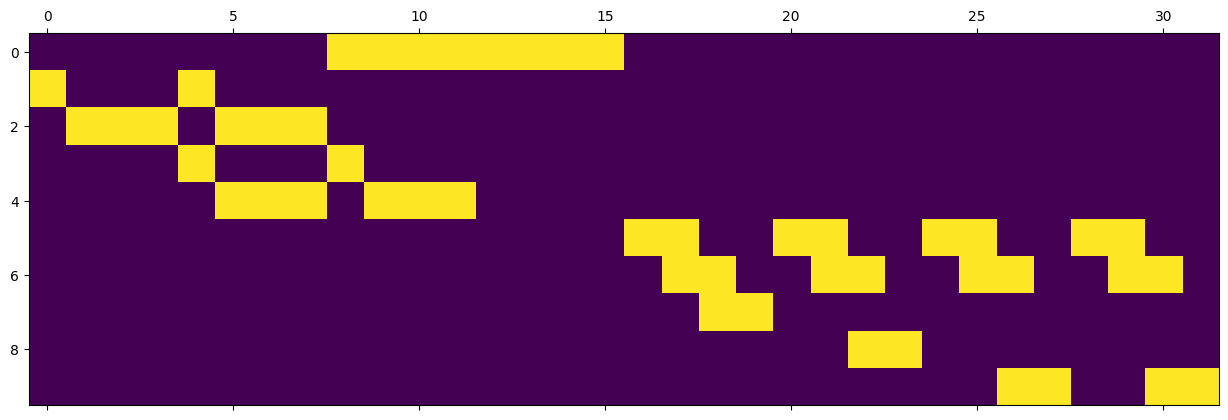

In [11]:
"""Construct the parity check matrices"""
pcheckX = lat.pcheckX()
pcheckZ = lat.pcheckZ()

pcheck = np.vstack([pcheckX, pcheckZ])
plt.matshow(pcheck)

In [12]:
gate_rates = [0.04, 0.04, 0.04]
meas_rates = [0.002, 0.002, 0.002]
num_stab_meas_rounds = 4

pcheckX = lat.pcheckX()
pcheckZ = lat.pcheckZ()
pcheck = np.vstack((pcheckX, pcheckZ))

# Sample a random error
err = random_pauli(lat.size(), gate_rates)
total_error = pauli2vector(err)
syndromeX_stream = np.zeros((num_stab_meas_rounds, len(pcheckX)), dtype=int)
syndromeZ_stream = np.zeros((num_stab_meas_rounds, len(pcheckZ)), dtype=int)

# Can wrap this in loop for phenomenological loop
for r in range(num_stab_meas_rounds):
    syndromeX = twisted_product(pcheckX, total_error)
    syndromeZ = twisted_product(pcheckZ, total_error)
    syndromeX_stream[r] = syndromeX
    syndromeZ_stream[r] = syndromeZ
    err = random_pauli(lat.size(), meas_rates)
    total_error = np.mod(total_error + pauli2vector(err), 2)

print("SYNDROME X STREAM: " + str(syndromeX_stream))
print("SYNDROME Z STREAM: " + str(syndromeZ_stream))
print("TOTAL ERROR: " + str(total_error))

SYNDROME X STREAM: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
SYNDROME Z STREAM: [[1 0 0 1 0]
 [1 0 0 1 0]
 [1 0 0 1 0]
 [1 0 0 1 0]]
TOTAL ERROR: [0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0]


## Defining Detector Model
* As opposed to a syndrome-based model, a detector model is utilized in situations where syndrome measurements may be faulty
    * Therefore, from one round of syndrome measurements to the next, the results may differ. The way in which these differences are captured is via the Detector Error Model

* Compare parity of syndrome measurements from one round of measurements to the next.

In [13]:
class DetectionEventDetector:
    def __init__(self, syndrome_stream):
        self.syndrome_stream = syndrome_stream 
        self.num_rounds = len(syndrome_stream)
        self.num_checks = len(syndrome_stream[0])
        self.detector_graph = nx.empty_graph()
        self.recorded_events = False
        self.detector_events = np.zeros((self.num_rounds, self.num_checks), dtype=int)

    def add_dummy_measurement(self):
        """ 
        We add a dummy measurement for time t = 0 to deal with detector model edge case for very 
        set of syndrome measurements.
        """
        self.syndrome_stream = np.vstack((self.syndrome_stream[0],self.syndrome_stream))

    def record_detector_events(self):
        """ 
        Construct detector events based on syndrome stream information 
        by XORing adjacent sets of syndrome measurements.
        """

        # Add dummy measurements for t = 0
        self.add_dummy_measurement()

        # XOR adjacent syndrome measurements and record
        for i in range(self.num_rounds):
            self.detector_events[i] = np.mod(self.syndrome_stream[i] + self.syndrome_stream[i + 1], 2)
        self.recorded_events = True
        return self.detector_events

    def construct_detector_graph(self):
        """ 
        Based on detection events, we construct a matching graph that can be fed into 
        MWPM or UF.
        """
        if (self.recorded_events == False):
            self.record_detector_events()

        # Add a 'boundary' node to graph
        self.detector_graph.add_node('boundary')
        
        # Label nodes according to bits being 0 or 1
        # - '0' --> s_(i,j)
        # - '1' --> ms_(i,j)
        for i in range(len(self.detector_events)):
            for j in range(len(self.detector_events[0])):
                if (self.detector_events[i][j] == 0):
                    self.detector_graph.add_node('s-' + str(i+1) + '-' + str(j))
                else:
                    self.detector_graph.add_node('ms-' + str(i + 1) + '-' + str(j))
        
        # Add edges to graph
        for i in range(len(self.detector_events)):
            for j in range(len(self.detector_events[0])):
                pass
                
def define_circuit_level_tanner_graph(num_checks, num_stab_meas_rounds):
    """ 
    Construct a Tanner Graph for circuit-level noise:
    - Check Node <=> Detection Event
    - Variable Node <=> Elementary Error Process
    - Edges <=> Variable Node (Elementary Error Process) adjacent to Check Nodes corresponding
                to detection events that get flipped by error process
    """
    cl_tanner_graph = nx.empty_graph()

    # Define set of Check Nodes 
    

    # Define set of Variable Nodes


    

In [14]:
detector_X = DetectionEventDetector(syndromeX_stream)
detector_Z = DetectionEventDetector(syndromeZ_stream)

detector_X_events = detector_X.record_detector_events()
detector_Z_events = detector_Z.record_detector_events()

print("SYNDROME X STREAM: " + str(syndromeX_stream), "\nDETECTOR X EVENTS: " + str(detector_X_events))

SYNDROME X STREAM: [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]] 
DETECTOR X EVENTS: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


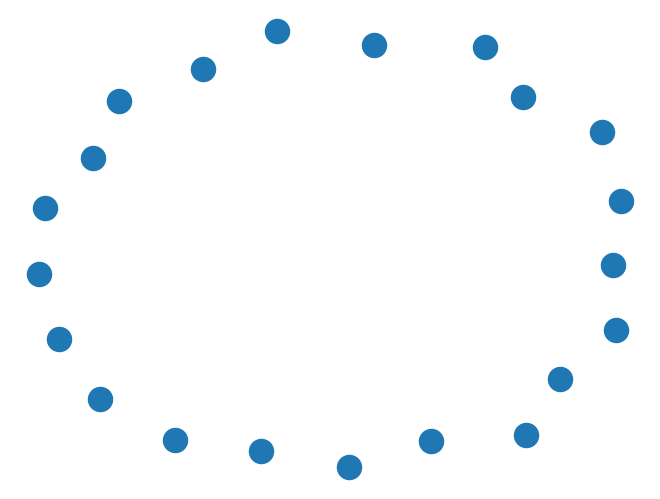

In [15]:
detector_X.construct_detector_graph()
nx.draw(detector_X.detector_graph)